In [2]:
cd ../src

/home/sankha/Documents/programs/ML/densityNN/src


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from lib.density.utils import divergences, OptimizeNormalKL
from scipy.stats import multivariate_normal, norm

# Sampling from a Distribution

## 1. Sampling from Standard Distributions

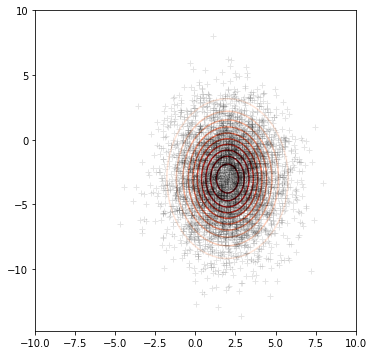

In [63]:
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
theta = np.array(list(zip(X.flatten(), Y.flatten())))

mu    = np.array([2, -3])
sigma = np.array([
    [3, 0],
    [0, 8]
])

prob = multivariate_normal.pdf( theta, mu, sigma )
probPlot = prob.reshape(100, 100)

samples = np.random.multivariate_normal( mu, sigma, 5000 )

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.plot(samples[:,0], samples[:,1], '+', mec='k', alpha=0.1)
plt.contour(X, Y, probPlot, cmap=plt.cm.Reds, levels=10)
plt.show()
plt.close('all')

## 2. Rejection Sampling

In this sampling method, we shall generate samples based upon the pdf. Note that this is a particularly slow process, and you may want to stay away from this. Sometimes, however, this might be the only method that is appropriate.

In [69]:
class RejectionSamplerUniform():
    
    def __init__(self, pdf, ranges=None):
        self.pdf = pdf
        self.ranges = ranges
        if ranges is not None:
            self.d = len(ranges)
        return
    
    def sample(self, N, ranges = None, maxIter=10000):
        
        result = None
        i = 0
        while (result is None) or len(result) < N:
            
            assert not ((ranges is None) and (self.ranges is None)), 'Unspecified range'
            if ranges is None:
                ranges = self.ranges
            self.d = len(ranges)
            lower, upper = zip(*ranges)
            x = np.random.uniform( lower, upper, (N, self.d) )
            p_x = self.pdf(x)

            mask = np.random.uniform(size=N) < p_x
            values = x[mask]
            
            if result is None:
                result = values
            else:
                result = np.vstack((result, values))
                
            i += 1
            if (maxIter is not None) and i >=maxIter:
                break

        result = result[:N]
        return result

In [61]:
rSampler = RejectionSamplerUniform( multivariate_normal(mu, sigma).pdf )

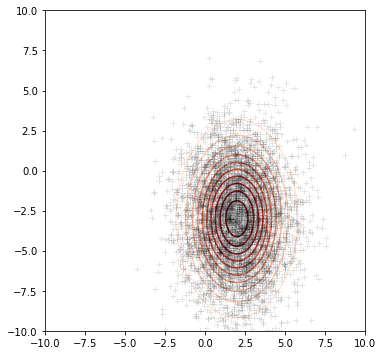

In [62]:
ranges = [[-10, 10], [-10, 10]]
N = 5000
samples = rSampler.sample(N, ranges)

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.plot(samples[:,0], samples[:,1], '+', mec='k', alpha=0.1)
plt.contour(X, Y, probPlot, cmap=plt.cm.Reds, levels=10)
plt.show()
plt.close('all')

## 3. Importance Sampling

Importance Sampling is the idea that we want to solve the integral of the form:

\begin{equation*}
\mathbb E(f) = \int_{-\infty}^{\infty} f(\mathbf w) p(\mathbf w)  d \mathbf w
\end{equation*}

It is entirely possible that one samples from the distribution $p(\mathbf w)$. Under this formulation, the equation for importance sampling (in the limit of infinite samples $N$) would be given by the following:

\begin{align*}
\mathbb E(f) &= \int_{-\infty}^{\infty} f(\mathbf w) p(\mathbf w)  d \mathbf w \\
             &= \frac 1 N \sum_{i=1}^N {f(w_i)}, w_i \sim p(\mathbf w)
\end{align*}


In [70]:
class ImportanceSampleIntegrateUniform():
    
    def __init__(self, f, p, ranges=None):
        self.f = f
        self.p = p
        self.d = None
        self.ranges = ranges
        if ranges is not None:
            self.d = len(ranges)
        return
    
    def integrate(self, N, ranges = None):
        
        result = None
        if ranges is None:
            ranges = self.ranges
            
        assert ranges is not None, 'Ranges not provided for uniform sampling'
        d = len(ranges)
        
        rSamples = RejectionSamplerUniform(self.p, ranges)
        samples = rSamples.sample(N)
        result = self.f( samples ).sum()/N
        
        return result

In [71]:
def f(x):
    return (x ** 2).sum(axis=1)

ranges = [[-10, 10], [-10, 10]]
N = 5000

impSampleInt = ImportanceSampleIntegrateUniform( f, multivariate_normal(mu, sigma).pdf )




In [80]:
for N in tqdm([10, 100, 1000, 10000]):
    result = []
    for j in tqdm(range(100)):
        r = impSampleInt.integrate(N, ranges)
        result.append(r)
    result = np.array(result)
    print(f'{N:10d} --> {result.mean()} (+- {result.std()})')

        10 --> 24.208244825600012 (+- 6.61095781325302)


       100 --> 23.29823198650377 (+- 2.0299857840493996)


      1000 --> 23.258481782496595 (+- 0.6253296895373959)


     10000 --> 23.311456849296682 (+- 0.1850370692393244)

